In [50]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Concatenate, GaussianNoise, UpSampling2D, Conv2DTranspose, Conv2D, Dense, Lambda, Input, Flatten, Reshape, BatchNormalization, ReLU, LeakyReLU, MaxPooling2D
from tensorflow.keras.models import Model, load_model
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



import os
import glob

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [270]:
import numpy as np
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [500]:
# network parameters
width = 64
height = 64
latent_dim = 100
n_conds = 40


# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=(width,height,3), name='encoder_input')
condition = Input(shape=(n_conds,), name='encoder_condition')

x = GaussianNoise(1)(inputs) #Noise layer for denoising VAE
x = Conv2D(16, 3, strides=2, padding='same')(inputs)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(32, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(64, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)

(_,h,w,c) = x.shape

x = Flatten()(x)

x = Concatenate()([x,condition])

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model([inputs,condition], [z_mean, z_log_var, z, condition], name='encoder')
encoder.summary()


# # build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
decoder_condition = Input(shape=(n_conds,), name='decoder_condition')

x = Concatenate()([latent_inputs,decoder_condition])
x = Dense(h*w*c, activation='relu')(x)
x = Reshape((h,w,c))(x)
x = Conv2D(128,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(64,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(32,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)
x = Conv2D(16,5, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU(0.1)(x)
x = UpSampling2D()(x)

outputs = Conv2D(3,3, strides=1, activation='sigmoid', padding='same')(x)


# # instantiate decoder model
decoder = Model([latent_inputs,decoder_condition], outputs, name='decoder')
decoder.summary()

# # instantiate VAE model
outputs = decoder([encoder([inputs, condition])[2], encoder([inputs, condition])[3]])
vae = Model([inputs, condition], outputs, name='cnn_vae')
vae.summary()
history = []

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 32, 32, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_80 (BatchNo (None, 32, 32, 16)   64          conv2d_90[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_80 (LeakyReLU)      (None, 32, 32, 16)   0           batch_normalization_80[0][0]     
____________________________________________________________________________________________

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_condition_10:0
Model: "cnn_vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
encoder_condition (InputLayer)  [(None, 40)]         0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 100), (None, 516200      encoder_input[0][0]              
                                                                 encoder_condition[0][0]          
                                                   

In [59]:
encoder([inputs, condition])[2]

<tf.Tensor 'encoder_11/Identity_2:0' shape=(None, 100) dtype=float32>

In [268]:
#Beta VAE warmup
from tensorflow.keras.callbacks import Callback
class Warmup(Callback):
    def __init__(self, beta, warmup_epoch):
        self.warmup_epoch = warmup_epoch
        self.beta = beta

    def on_epoch_end(self, epoch, logs={}):
        value = (epoch/self.warmup_epoch) * (epoch <= self.warmup_epoch) + 1.0 * (epoch > self.warmup_epoch)
        K.set_value(self.beta, value)
        print(f' epoch {epoch}, beta = {K.get_value(self.beta)}')

def vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return K.mean(reconstruction_loss + kl_loss)
 
    
beta = K.variable(0.0)
def beta_vae_loss(y_true, y_pred):
    reconstruction_loss = mse(K.flatten(y_true), K.flatten(y_pred))
    reconstruction_loss *= width*height # common practice to scale with w*h
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    kl_loss * beta
    return K.mean(reconstruction_loss + kl_loss)




In [26]:
import cv2
import numpy as np
import glob 
import pandas as pd

def data_loader(file_path):
    img_paths = glob.glob(file_path + '/0*[0-9][0-9][0-9].jpg')
    data = []
    for img_path in img_paths:
        data.append(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB) / 255.0)

    return np.array(data)
X = data_loader('../celeba-clean-64/')
df = pd.read_csv('./celeba-attribs.csv')
c = df[list(df.columns[1:])].to_numpy()


In [27]:
X_c = X, c[:X.shape[0],:]

In [162]:
def encode_to_attribs(encoded):
    for present, attrib in zip(encoded, list(df.columns[1:])):
        if present == 1:
            print(attrib)

In [501]:
optimizer = Adam(0.0008)
vae.compile(optimizer=optimizer, loss=vae_loss, experimental_run_tf_function=False)
loss_curve = []

In [502]:
import time
epochs = 1000
batch_size = 32

train_data = (X_c[0][:15000], X_c[1][:15000])

noise = np.random.normal(0,1, 100)

num_batches = int(len(train_data[0]) // batch_size)

for epoch in range(epochs):
    start = time.time()
    print(f'Epoch [{epoch}/{epochs-1}]...'.ljust(20), end = '')
    np.random.seed(epoch)
    np.random.shuffle(train_data[0])
    np.random.seed(epoch)
    np.random.shuffle(train_data[1])
    
    loss = 0
    
    for index in range(num_batches):
        img_input = train_data[0][index*batch_size: batch_size*(index+1)]
        condition_input = train_data[1][index*batch_size: batch_size*(index+1)]
        loss += vae.train_on_batch([img_input, condition_input], img_input)
    
    loss /= num_batches
    print(f'...{time.time()-start:.3f}(s) loss: {loss:.3f}')
    loss_curve.append(loss)


Epoch [0/999]...    ...13.171(s) loss: 169.411
Epoch [1/999]...    ...9.959(s) loss: 131.926
Epoch [2/999]...    ...9.887(s) loss: 121.893
Epoch [3/999]...    ...9.906(s) loss: 118.001
Epoch [4/999]...    ...9.885(s) loss: 114.994
Epoch [5/999]...    ...9.900(s) loss: 113.525
Epoch [6/999]...    ...9.870(s) loss: 111.740
Epoch [7/999]...    ...9.858(s) loss: 110.738
Epoch [8/999]...    ...9.924(s) loss: 109.558
Epoch [9/999]...    ...9.905(s) loss: 108.840
Epoch [10/999]...   ...9.906(s) loss: 108.643
Epoch [11/999]...   ...9.930(s) loss: 107.850
Epoch [12/999]...   ...9.857(s) loss: 107.173
Epoch [13/999]...   ...9.878(s) loss: 106.618
Epoch [14/999]...   ...9.787(s) loss: 106.465
Epoch [15/999]...   ...9.837(s) loss: 105.544
Epoch [16/999]...   ...9.804(s) loss: 105.210
Epoch [17/999]...   ...9.664(s) loss: 104.845
Epoch [18/999]...   ...9.557(s) loss: 104.632
Epoch [19/999]...   ...9.588(s) loss: 104.160
Epoch [20/999]...   ...9.553(s) loss: 103.792
Epoch [21/999]...   ...9.598(s) l

Epoch [181/999]...  ...9.980(s) loss: 86.711
Epoch [182/999]...  ...10.003(s) loss: 86.893
Epoch [183/999]...  ...9.972(s) loss: 86.754
Epoch [184/999]...  ...9.976(s) loss: 86.703
Epoch [185/999]...  ...9.964(s) loss: 86.702
Epoch [186/999]...  ...9.993(s) loss: 86.673
Epoch [187/999]...  ...10.005(s) loss: 86.793
Epoch [188/999]...  ...9.982(s) loss: 86.569
Epoch [189/999]...  ...10.007(s) loss: 86.488
Epoch [190/999]...  ...9.943(s) loss: 86.475
Epoch [191/999]...  ...9.973(s) loss: 86.433
Epoch [192/999]...  ...10.016(s) loss: 86.361
Epoch [193/999]...  ...9.961(s) loss: 86.125
Epoch [194/999]...  ...10.003(s) loss: 86.253
Epoch [195/999]...  ...9.979(s) loss: 86.278
Epoch [196/999]...  ...9.943(s) loss: 86.109
Epoch [197/999]...  ...9.983(s) loss: 86.304
Epoch [198/999]...  ...9.968(s) loss: 86.164
Epoch [199/999]...  ...9.972(s) loss: 86.110
Epoch [200/999]...  ...9.994(s) loss: 85.810
Epoch [201/999]...  ...10.022(s) loss: 85.935
Epoch [202/999]...  ...9.986(s) loss: 85.835
Epoc

Epoch [362/999]...  ...9.987(s) loss: 81.036
Epoch [363/999]...  ...9.958(s) loss: 81.053
Epoch [364/999]...  ...9.962(s) loss: 81.103
Epoch [365/999]...  ...9.972(s) loss: 81.073
Epoch [366/999]...  ...9.803(s) loss: 81.057
Epoch [367/999]...  ...9.676(s) loss: 80.939
Epoch [368/999]...  ...9.694(s) loss: 81.001
Epoch [369/999]...  ...9.681(s) loss: 81.020
Epoch [370/999]...  ...9.670(s) loss: 80.952
Epoch [371/999]...  ...9.696(s) loss: 80.901
Epoch [372/999]...  ...9.710(s) loss: 80.808
Epoch [373/999]...  ...9.687(s) loss: 80.781
Epoch [374/999]...  ...9.676(s) loss: 80.933
Epoch [375/999]...  ...9.693(s) loss: 80.780
Epoch [376/999]...  ...9.707(s) loss: 80.706
Epoch [377/999]...  ...9.681(s) loss: 80.804
Epoch [378/999]...  ...9.762(s) loss: 80.756
Epoch [379/999]...  ...9.948(s) loss: 80.782
Epoch [380/999]...  ...10.009(s) loss: 80.776
Epoch [381/999]...  ...9.958(s) loss: 80.773
Epoch [382/999]...  ...9.953(s) loss: 80.605
Epoch [383/999]...  ...9.939(s) loss: 80.632
Epoch [38

Epoch [543/999]...  ...9.979(s) loss: 78.166
Epoch [544/999]...  ...9.992(s) loss: 78.009
Epoch [545/999]...  ...9.957(s) loss: 78.149
Epoch [546/999]...  ...9.965(s) loss: 77.997
Epoch [547/999]...  ...9.978(s) loss: 77.967
Epoch [548/999]...  ...10.014(s) loss: 77.935
Epoch [549/999]...  ...9.980(s) loss: 77.921
Epoch [550/999]...  ...9.966(s) loss: 77.855
Epoch [551/999]...  ...10.000(s) loss: 77.967
Epoch [552/999]...  ...9.970(s) loss: 77.988
Epoch [553/999]...  ...9.972(s) loss: 77.886
Epoch [554/999]...  ...9.982(s) loss: 77.986
Epoch [555/999]...  ...9.987(s) loss: 77.890
Epoch [556/999]...  ...9.979(s) loss: 77.897
Epoch [557/999]...  ...9.986(s) loss: 77.886
Epoch [558/999]...  ...10.001(s) loss: 77.891
Epoch [559/999]...  ...9.968(s) loss: 77.883
Epoch [560/999]...  ...9.990(s) loss: 77.784
Epoch [561/999]...  ...9.981(s) loss: 77.697
Epoch [562/999]...  ...10.008(s) loss: 77.831
Epoch [563/999]...  ...10.000(s) loss: 77.880
Epoch [564/999]...  ...9.954(s) loss: 77.826
Epoch

Epoch [725/999]...  ...9.970(s) loss: 76.084
Epoch [726/999]...  ...9.979(s) loss: 76.180
Epoch [727/999]...  ...9.982(s) loss: 76.082
Epoch [728/999]...  ...9.996(s) loss: 76.144
Epoch [729/999]...  ...9.969(s) loss: 76.042
Epoch [730/999]...  ...9.980(s) loss: 76.240
Epoch [731/999]...  ...9.968(s) loss: 76.302
Epoch [732/999]...  ...9.975(s) loss: 76.183
Epoch [733/999]...  ...9.945(s) loss: 76.105
Epoch [734/999]...  ...9.966(s) loss: 76.108
Epoch [735/999]...  ...9.959(s) loss: 76.118
Epoch [736/999]...  ...9.963(s) loss: 76.166
Epoch [737/999]...  ...9.988(s) loss: 76.092
Epoch [738/999]...  ...9.980(s) loss: 76.180
Epoch [739/999]...  ...9.977(s) loss: 76.131
Epoch [740/999]...  ...10.004(s) loss: 76.023
Epoch [741/999]...  ...9.947(s) loss: 75.921
Epoch [742/999]...  ...9.983(s) loss: 76.272
Epoch [743/999]...  ...9.999(s) loss: 76.064
Epoch [744/999]...  ...9.984(s) loss: 76.127
Epoch [745/999]...  ...9.989(s) loss: 76.050
Epoch [746/999]...  ...9.972(s) loss: 76.034
Epoch [74

Epoch [907/999]...  ...10.000(s) loss: 74.929
Epoch [908/999]...  ...9.993(s) loss: 74.946
Epoch [909/999]...  ...9.974(s) loss: 74.896
Epoch [910/999]...  ...9.981(s) loss: 74.924
Epoch [911/999]...  ...9.961(s) loss: 74.775
Epoch [912/999]...  ...9.960(s) loss: 74.942
Epoch [913/999]...  ...9.953(s) loss: 74.875
Epoch [914/999]...  ...10.004(s) loss: 74.901
Epoch [915/999]...  ...9.972(s) loss: 74.864
Epoch [916/999]...  ...9.997(s) loss: 74.800
Epoch [917/999]...  ...9.985(s) loss: 74.809
Epoch [918/999]...  ...9.970(s) loss: 74.811
Epoch [919/999]...  ...9.965(s) loss: 74.876
Epoch [920/999]...  ...10.014(s) loss: 74.847
Epoch [921/999]...  ...9.965(s) loss: 74.834
Epoch [922/999]...  ...9.986(s) loss: 74.861
Epoch [923/999]...  ...9.946(s) loss: 74.822
Epoch [924/999]...  ...9.939(s) loss: 74.834
Epoch [925/999]...  ...9.980(s) loss: 74.878
Epoch [926/999]...  ...9.953(s) loss: 74.764
Epoch [927/999]...  ...9.985(s) loss: 74.874
Epoch [928/999]...  ...9.976(s) loss: 74.896
Epoch [

In [539]:
decoder.save_weights('./cond-decoder-wieght-1k-15kimgs.h5')
decoder.save('./decoder-1k-15kimgs.h5')

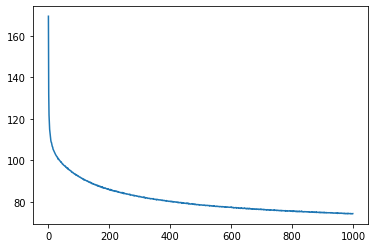

In [503]:
plt.plot(loss_curve)

In [223]:
val_imgs = X_c[0][5000:5010]
val_conds = X_c[1][5000:5010]

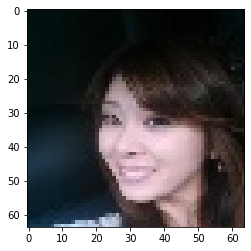

Attractive
Bags_Under_Eyes
Bangs
Big_Lips
Brown_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Smiling
Wavy_Hair
Wearing_Earrings
Wearing_Lipstick
Young
None


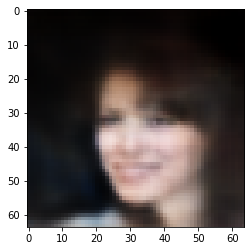

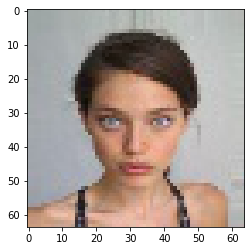

Attractive
Black_Hair
Heavy_Makeup
No_Beard
Oval_Face
Pointy_Nose
Wearing_Lipstick
Young
None


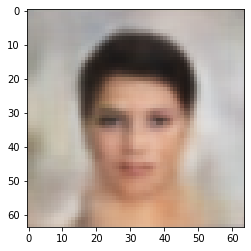

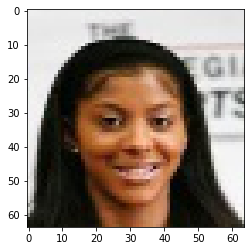

Arched_Eyebrows
Attractive
Black_Hair
High_Cheekbones
Mouth_Slightly_Open
No_Beard
Oval_Face
Smiling
Young
None


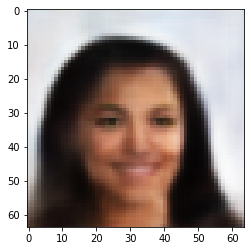

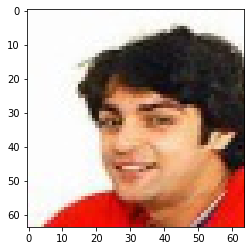

Big_Lips
Black_Hair
Blurry
Bushy_Eyebrows
High_Cheekbones
Male
Mouth_Slightly_Open
No_Beard
Smiling
Wavy_Hair
Young
None


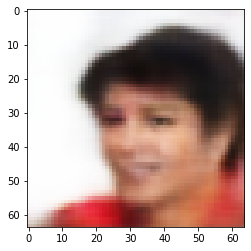

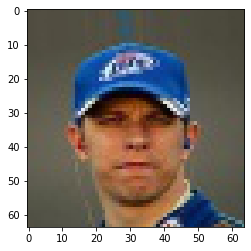

Male
Narrow_Eyes
No_Beard
Wearing_Hat
Young
None


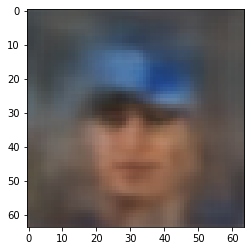

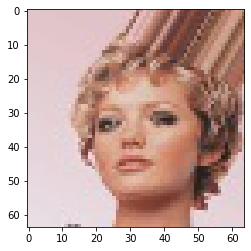

Arched_Eyebrows
Attractive
Heavy_Makeup
No_Beard
Pointy_Nose
Wavy_Hair
Wearing_Lipstick
Young
None


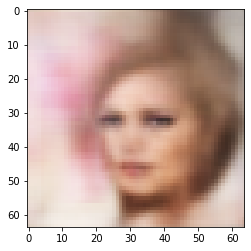

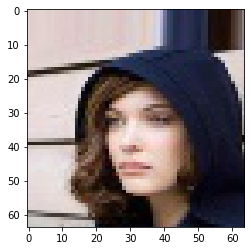

Big_Lips
Brown_Hair
Heavy_Makeup
No_Beard
Pointy_Nose
Wearing_Hat
Wearing_Lipstick
Young
None


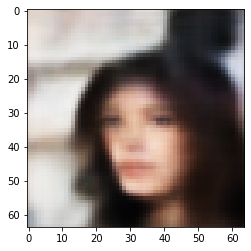

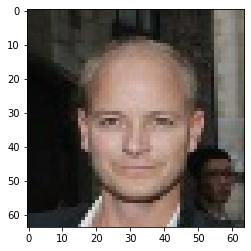

Bald
Male
No_Beard
Pointy_Nose
Receding_Hairline
None


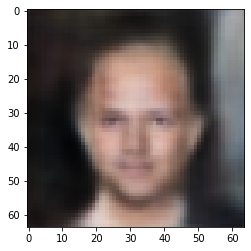

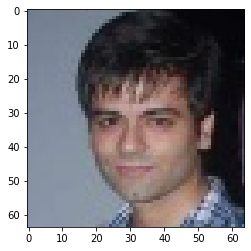

Black_Hair
Bushy_Eyebrows
High_Cheekbones
Male
No_Beard
Smiling
Straight_Hair
Young
None


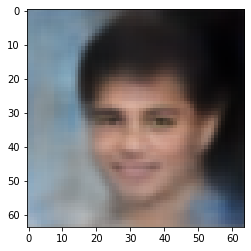

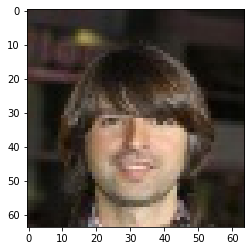

5_o_Clock_Shadow
Attractive
Bangs
Brown_Hair
Male
Mouth_Slightly_Open
No_Beard
Smiling
Straight_Hair
Young
None


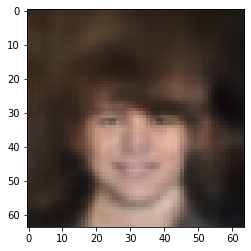

In [504]:
for image, cond in zip(val_imgs, val_conds):
    plt.imshow(image)
    plt.show()
    print(encode_to_attribs(cond))
    plt.imshow(vae.predict([np.array([image]),np.array([cond])])[0])
    
    
    plt.show()

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [429]:
print(f"=1, ".join(list(df.columns[1:])))

5_o_Clock_Shadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young


In [430]:
conditions = None
@interact(five_o_Clock_Shadow=1, Arched_Eyebrows=1, Attractive=1, Bags_Under_Eyes=1, Bald=1, Bangs=1, Big_Lips=1, Big_Nose=1, Black_Hair=1, Blond_Hair=1, Blurry=1, Brown_Hair=1, Bushy_Eyebrows=1, Chubby=1, Double_Chin=1, Eyeglasses=1, Goatee=1, Gray_Hair=1, Heavy_Makeup=1, High_Cheekbones=1, Male=1, Mouth_Slightly_Open=1, Mustache=1, Narrow_Eyes=1, No_Beard=1, Oval_Face=1, Pale_Skin=1, Pointy_Nose=1, Receding_Hairline=1, Rosy_Cheeks=1, Sideburns=1, Smiling=1, Straight_Hair=1, Wavy_Hair=1, Wearing_Earrings=1, Wearing_Hat=1, Wearing_Lipstick=1, Wearing_Necklace=1, Wearing_Necktie=1, Young=1,)
def g(five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young):
    global conditions
    conditions = np.array([five_o_Clock_Shadow, Arched_Eyebrows, Attractive, Bags_Under_Eyes, Bald, Bangs, Big_Lips, Big_Nose, Black_Hair, Blond_Hair, Blurry, Brown_Hair, Bushy_Eyebrows, Chubby, Double_Chin, Eyeglasses, Goatee, Gray_Hair, Heavy_Makeup, High_Cheekbones, Male, Mouth_Slightly_Open, Mustache, Narrow_Eyes, No_Beard, Oval_Face, Pale_Skin, Pointy_Nose, Receding_Hairline, Rosy_Cheeks, Sideburns, Smiling, Straight_Hair, Wavy_Hair, Wearing_Earrings, Wearing_Hat, Wearing_Lipstick, Wearing_Necklace, Wearing_Necktie, Young])


interactive(children=(IntSlider(value=1, description='five_o_Clock_Shadow', max=3, min=-1), IntSlider(value=1,…

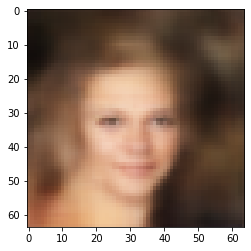

In [564]:
mu, sigma = 0, 1 #mean and standard deviation
#s = np.random.normal(mu, sigma, latent_dim)
plt.imshow(decoder.predict([np.array([s]),np.array([conditions])])[0])
plt.show()

In [510]:
conditions

array([-1, -1, -1, -1, -1,  0,  0, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1,  0, -1,  0, -1, -1,
       -1, -1,  3, -1, -1,  1])

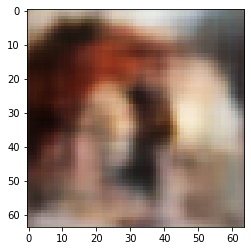

In [154]:
plt.imshow(decoder.predict([np.array([s]),np.array([np.ones(40)*1])])[0])
plt.show()

In [99]:
vae.save('vanilla-VAE-150.h5', save_format='tf')

In [124]:
encoded = encoder.predict(np.array([imgs[idx]]))[0]

In [129]:
warmup_til_epoch=50
for epoch in range(100):
    value = (epoch/warmup_til_epoch) * (epoch <= warmup_til_epoch) + 1.0 * (epoch > warmup_til_epoch)
    print(value)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


In [126]:
s

array([-1.08106999,  0.32013323, -1.55818613, -0.45026854, -1.66310395,
        0.78569422, -1.39762405,  0.07338019,  1.1939133 ,  0.4395131 ,
        0.84212601,  0.72813559, -0.20395568, -0.55190861,  0.91331887,
       -0.52396943,  0.42840624,  1.52424608, -1.03515727, -0.56327838,
       -0.20883481,  0.21993302,  0.42961978, -0.23346862,  0.41999356,
       -1.33034769,  0.45838368,  0.56152947, -0.03538979, -1.64144032,
       -0.4171319 ,  1.4437737 , -0.3009611 ,  1.4147419 ,  0.37861709,
        0.51136094, -1.66606614, -0.78132097,  0.26521417, -2.84087669,
        0.14570408, -1.30468342,  1.07145666, -0.19641146, -0.79491905,
       -0.68028141,  0.07673936, -1.65081373,  0.41551591, -1.56793549,
       -0.53741953,  1.91968439, -0.45774273, -0.3253923 ,  0.26121327,
       -1.80431887, -1.50881659, -1.12793814,  0.41378639, -0.40247553,
        1.61163988,  0.21441996, -0.7190945 ,  0.32763873,  0.1133167 ,
       -0.7985691 ,  1.21927564, -0.06176024,  0.15438005, -0.24

In [6]:
vae = load_model('./vanilla-VAE-150.tf')

SystemError: unknown opcode

In [39]:
vae.load_weights('./DVAE-150.h5')

ValueError: You are trying to load a weight file containing 12 layers into a model with 20 layers.

In [29]:
vae.layers[2].load_weights('./DVAE-150.h5',by_name=True)

In [30]:
encoder = vae.layers[1]
decoder = vae.layers[2]

input_layer = Input(shape=(64,64,3))
vae.layers

In [17]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 64, 64, 16)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [37]:
flatten_model(vae)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: encoder_input_4:0
Note that input tensors are instantiated via `tensor = 

ValueError: Input 0 of layer z_log_var is incompatible with the layer: expected axis -1 of input shape to have value 4096 but received input with shape [None, 200]

In [36]:
def flatten_model(model_nested):
    layers_flat = []
    for layer in model_nested.layers:
        try:
            layers_flat.extend(layer.layers)
        except AttributeError:
            layers_flat.append(layer)
    model_flat = tf.keras.models.Sequential(layers_flat)
    return model_flat

In [2]:
load_model('./vanilla-VAE-150.h5')

SystemError: unknown opcode